# Problem 2 Word2Vec & Seq2Seq Models
---------

## Setup

In [53]:
import os, sys, tqdm, json, pickle, random, warnings
from typing import List, Optional

import numpy as np, pandas as pd

import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

import torch.nn.functional as F

import torch, torch.nn as nn, torch.optim as optim
import pytorch_lightning as pl
from torch.utils import data

from gensim.models import Word2Vec, Phrases
from gensim.test.utils import common_texts
import gensim, gensim.downloader as gensim_api
from gensim import corpora

from gensim.parsing.preprocessing import remove_stopwords, preprocess_documents
from gensim.utils import simple_preprocess

pl.seed_everything(3)

Global seed set to 3


3

### Global Variables

**NOTE**: you can find other `gensim` datasets [here](https://github.com/RaRe-Technologies/gensim-data#datasets)

In [54]:
SAVE_DIR = os.path.abspath('.')

W2V_FILE = os.path.join(SAVE_DIR, 'word2vec.pth')

CORPUS = 'text8'# 'glove-wiki-gigaword-200'

TXT_FILE = os.path.join(SAVE_DIR, f'{CORPUS}.pkl')

OVERWRITE = False

VEC_SIZE = 50 #10

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = 'cpu'

SAVE_DIR

'/Users/default/Google Drive/currentDocumants/studies/Master/6.Semester/deep_learning/pset/pset3/problem 2'

## Part 1

### Fetch you text corpus

**TODO**: generate your own word-vector embedding using a text corpus of _your_ choice of at least **500** words. You may use `gensim`'s corpora.

Feel free to play with hyperparmaters in the notebook such as context size and embedding size.

In [55]:
corpus = gensim_api.load(CORPUS)

In [56]:
does_corpus_exist = os.path.isfile(TXT_FILE)

if not does_corpus_exist or OVERWRITE:
    corpus = gensim_api.load(CORPUS)
    with open(TXT_FILE, 'wb') as f:
        pickle.dump(corpus, f)

else:
    with open(TXT_FILE, 'rb') as f:
         corpus = pickle.load(f)

corpus

### Train your Word2Vec Model

**NOTE**: you are free to create your own Word2Vec model. You are welcome to use `gensim`. However for the pset you must at least _train_ a Word2Vec model!

In [57]:
W2V_FILE

'/Users/default/Google Drive/currentDocumants/studies/Master/6.Semester/deep_learning/pset/pset3/problem 2/word2vec.pth'

In [58]:
does_model_exist = os.path.isfile(W2V_FILE)

if not does_model_exist or OVERWRITE:
    w2v = Word2Vec(
        # NOTE: you can use either a list of strings (sentences)
        # or provide a corpus_file
        corpus, 
        
        # Dimensionality of the word vectors.
        vector_size=VEC_SIZE, 
        #size=VEC_SIZE, 

        # Maximum distance between the current and predicted word within a sentence.
        window=5, 

        # Ignores all words with total frequency lower than this.
        min_count=1,

        # Training algorithm: 1 for skip-gram; otherwise CBOW.
        sg = 1,
        
        # Use these many worker threads to train the model (=faster training 
        # with multicore machines).
        workers=32,

        # If 0, use the sum of the context word vectors. If 1, use the mean, 
        # only applies when cbow is used.
        cbow_mean = 1,

        # Number of iterations (epochs) over the corpus. (Formerly: iter)
        epochs=10#100
    )

    w2v.add_null_word()

    w2v.save(W2V_FILE)

else:

     w2v = Word2Vec.load(W2V_FILE)

In [59]:
def vec_math(model, *args, return_str_description:bool=False):    
    desc = ''
    func = np.add  
    # NOTE: vector_size  
    vect = None
    
    for arg in args:
        if arg == '+':
            desc += ' + '
            func = np.add
        elif arg == '-':
            desc += ' - '
            func = np.subtract
        elif arg == '/':
            desc += ' / '
            func = np.divide
        elif arg == '*':
            desc += ' * '
            func = np.multiply
        else:
            desc += arg
            curr = model.wv[arg]
            if vect is None:
                vect = curr.copy()
            else:
                vect = func(vect, curr)

    if return_str_description:
        return desc, vect

    return vect

#### Explore results

NOTE: here my model had 

$$
woman + man - king = girl
$$

and

$$
news + truth - lies = blogging
$$ 

In [60]:
# woman + man - king = ?
gsm_res = w2v.wv.most_similar(positive=['woman','man'], negative=['king'])[0]
gsm_res

('dumb', 0.7257739901542664)

In [61]:
# news + truth - lies = ?
gsm_res = w2v.wv.most_similar(positive=['news','truth'], negative=['lies'])[0]
gsm_res

('publicize', 0.7525402903556824)

In [62]:
w2v.wv.most_similar(positive=['lies'], topn = 10)

[('extends', 0.8267737030982971),
 ('occupies', 0.8245770335197449),
 ('lying', 0.8212238550186157),
 ('situated', 0.8177280426025391),
 ('reaches', 0.8083112835884094),
 ('encircles', 0.766158938407898),
 ('traverses', 0.7654803395271301),
 ('sits', 0.762751579284668),
 ('overlooks', 0.7599471211433411),
 ('encloses', 0.7521087527275085)]

#### Visualize

**TODO**: Plot these word embeddings (all words) by adjusting the code in the notebook.

You are able to adjust the plotting parameters to suit your needs for making a compelling visualization. 
Discuss what you notice in your embeddings. For example, using the introduction to Charles Darwin's "_On the Origin of Species_" 
as a text file, we obtain the embeddings in Figure 2

In [63]:
corpus

In [64]:
#extract words from corpus
all_words_from_corpus = []
for word in corpus:
    all_words_from_corpus.append(word)

#words_from_corpus = np.array(words_from_corpus).flatten()
all_words_from_corpus = np.concatenate(all_words_from_corpus)

In [65]:
#this does not terminate

#fig = plt.figure(figsize=(20, 8))
#lim_scale = 2

#ax = fig.add_subplot(1, 1, 1)

# Get the 50 most frequent words in the vocabulary
#words = [w for w, _ in w2v.wv.most_similar(positive=['king'], topn=20)]

#vecs = w2v.wv[all_words_from_corpus]

#min_vals = np.min(vecs, axis=0)
#max_vals = np.max(vecs, axis=0)  

#ax.set_xlim(min_vals[0] * lim_scale, max_vals[0] * lim_scale)
#ax.set_ylim(min_vals[1] * lim_scale, max_vals[1] * lim_scale)

#for j, vec in enumerate(vecs):
#    word = all_words_from_corpus[j]

    #print(vec)
#    plt.scatter(vec[0], vec[1])
#    plt.annotate(
#        word, xy=(0, 0),  xytext=(vec[0], vec[1]), 
#        arrowprops=dict(arrowstyle="<-"),
#        fontsize=8  
#    )

#plt.show()

**TODO**: Since this is too crowded to interpret, modify the code in the notebook to randomly select words to plot as long as there is space as shown in Figure 3

In [66]:
words_sample = np.random.choice(all_words_from_corpus, size=20, replace=False)

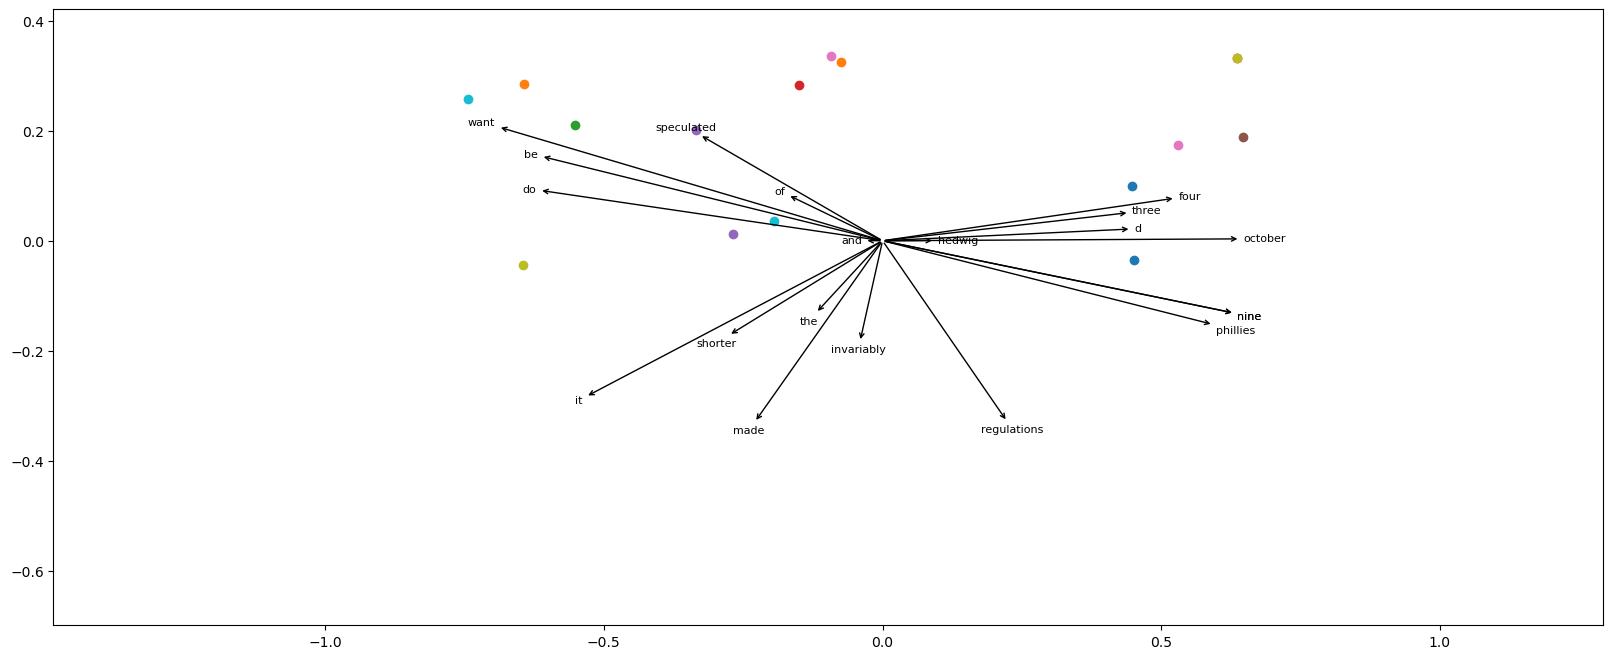

In [67]:
fig = plt.figure(figsize=(20, 8))
lim_scale = 2

ax = fig.add_subplot(1, 1, 1)

vecs = w2v.wv[words_sample]

min_vals = np.min(vecs, axis=0)
max_vals = np.max(vecs, axis=0)  

ax.set_xlim(min_vals[0] * lim_scale, max_vals[0] * lim_scale)
ax.set_ylim(min_vals[1] * lim_scale, max_vals[1] * lim_scale)

for j, vec in enumerate(vecs):
    word = words_sample[j]

    #print(vec)
    plt.scatter(vec[0], vec[40])
    plt.annotate(
        word, xy=(0, 0),  xytext=(vec[0], vec[1]), 
        arrowprops=dict(arrowstyle="<-"),
        fontsize=8  # Adjust the font size for readability
    )

plt.show()

subset, todo delete

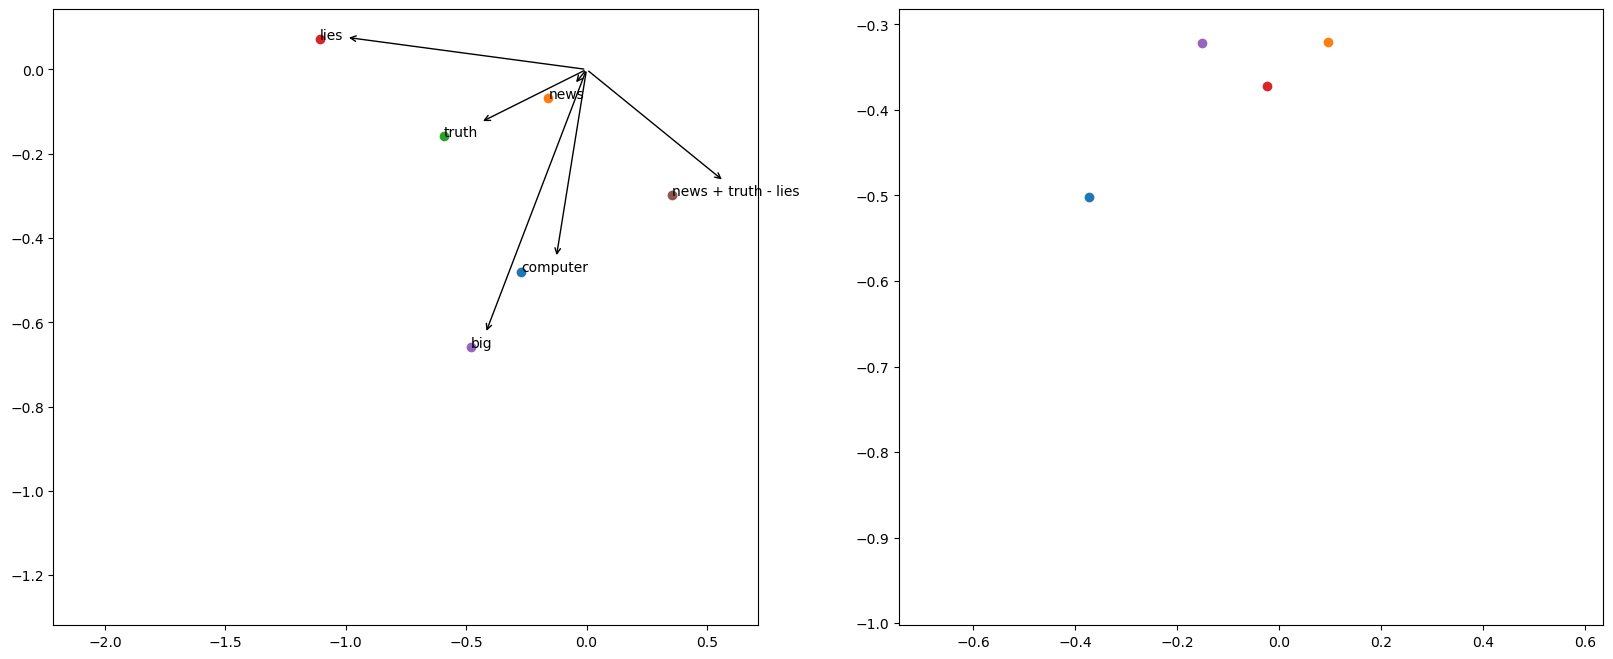

In [68]:
fig = plt.figure(figsize=(20, 8))
lim_scale = 2

word_groups = [
    'computer,news,truth,lies,big,news + truth - lies'.split(','), 
    'man,king,woman,queen,woman + man - king'.split(','), 
]

for i, words in enumerate(word_groups):
    ax = fig.add_subplot(1, 2, i+1)
    single_words = list(filter(lambda e: e.isalpha(), words))
    domath_words = list(filter(lambda e: not e.isalpha(), words))

    vecs = w2v.wv[single_words]
    for w in domath_words:        
        v = vec_math(w2v, *w.split())
        vecs = np.vstack((vecs, v))      

    min_vals = np.min(vecs, axis=0)
    max_vals = np.max(vecs, axis=0)  

    ax.set_xlim(min_vals[0] * lim_scale, max_vals[0] * lim_scale)
    ax.set_ylim(min_vals[1] * lim_scale, max_vals[1] * lim_scale)

    for j, vec in enumerate(vecs):
        word = words[j]

        plt.scatter(vec[0], vec[1])
        plt.annotate(
            word, xy=(0, 0),  xytext=(vec[0], vec[1]), 
            arrowprops=dict(arrowstyle="<-")
        )

## Part 2

### Dataset

dl_310_2

In [69]:
import os, sys, tqdm, json, pickle, random, warnings
from typing import List, Optional

import numpy as np, pandas as pd

import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

import torch, torch.nn as nn, torch.optim as optim
import pytorch_lightning as pl
from torch.utils import data

from gensim.models import Word2Vec, Phrases
from gensim.test.utils import common_texts
import gensim, gensim.downloader as gensim_api
from gensim import corpora

from gensim.parsing.preprocessing import remove_stopwords, preprocess_documents
from gensim.utils import simple_preprocess

pl.seed_everything(3)

Global seed set to 3


3

Whether or not you used `gensim` for training the `Word2Vec` model you will be using PyTorch Lightning for the `Seq2Seq` model. To make this easier on you, you will need to create a `data.Dataset` object which contains, at the very least, `__getitem__` and `__len__` methods to yield items during training. Below is an example which converts a `gensim` corpus paired batches of the first 300 words per doc.

In [70]:
class Seq2SeqTextDataset(data.Dataset):
    def __init__(self, corpus, keyed_vecs, reverse_target:bool=False):        
        self.corpus = corpus
        self.keyed_vecs = keyed_vecs
        
        docs = self.docs_from_corpus(corpus)
        self.docs = docs
        self.data = docs

        corpora_dct = corpora.Dictionary(docs)
        self.corpora_dct = corpora_dct

        bows = self.bows_from_docs(docs, corpora_dct)
        self.bows = bows
        
        self.reverse_target = reverse_target

    def docs_from_corpus(self, corpus):
        docs = [
            #simple_preprocess(remove_stopwords(' '.join(doc)))[:300] #will have to reduce this to 5
            simple_preprocess(remove_stopwords(' '.join(doc)))[:3]
            for doc in corpus
        ]
        return docs
        
    def bows_from_docs(self, docs, dct):
        return [dct.doc2bow(doc) for doc in docs]


    def __len__(self):        
        return int(len(self.docs))

    def __getitem__(self, idx):
        doc = self.docs[idx]

        source = torch.tensor([self.keyed_vecs.get_index(word) for word in doc])      
        
        target = [self.keyed_vecs.get_index(word, default=0) for word in doc]
        if self.reverse_target:
            target = target[::-1]
        target = torch.tensor(target)

        return source, target

### Seq2Seq Model

#### Encoder

**TODO**: fill in the `encode` method

In [71]:
class Encoder(nn.Module):
    def __init__(
        self, 
        n_vocabsize:int, n_embedding:int, n_hidden:int, n_layers:int, 
        dropout:Optional[float]=0.1, pretrained:Optional[np.ndarray]=None,
    ):
        super(Encoder, self).__init__()
                
        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        embedding = self.make_embedding_layer(n_vocabsize, n_embedding, pretrained)
        self.embedding = embedding

        # NOTE: depending on your dataset you may have to change batch_first
        self.lstm = nn.LSTM(n_embedding, n_hidden, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def make_embedding_layer(
        self, 
        n_vocabsize:int, 
        n_embedding:int,
        pretrained:Optional[np.ndarray]=None,
    ):
        if pretrained is not None:
            pretrained = np.array(pretrained)
            n_vocabsize, n_embedding = pretrained.shape
            
            self.n_vocabsize = n_vocabsize
            self.n_embedding = n_embedding

            pretrained = torch.FloatTensor(pretrained) 
            embedding = nn.Embedding.from_pretrained(pretrained)

        else:
            embedding = nn.Embedding(n_vocabsize, n_embedding)

        return embedding
    

    def encode(self, x):
       # TODO: fill this in
       embedding = self.embedding(x)
       embedding = self.dropout(embedding) #TODO: is this the right place for dropout?

       _, (hidden, cell) = self.lstm(embedding) #TODO save output?
       return hidden, cell
    
    def forward(self, x):
        return self.encode(x)

#### Decoder

**TODO**: fill in the `decode` method

In [72]:
class Decoder(nn.Module):
    def __init__(
        self,
        n_vocabsize:int, n_embedding:int, n_hidden:int, n_layers:int, 
        dropout:Optional[float]=0.1,
    ):
        super(Decoder, self).__init__()
        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(n_vocabsize, n_embedding)
        self.lstm = nn.LSTM(n_embedding, n_hidden, n_layers, dropout=dropout, batch_first=True) #TODO batch_first?
        
        self.fc_out = nn.Linear(n_hidden, n_vocabsize)
        self.dropout = nn.Dropout(dropout)

    def decode(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        prediction = self.fc_out(output.squeeze(1))
        prediction = self.dropout(prediction) #TODO: is this the right place for dropout?

        return prediction, hidden, cell
        

    
    def forward(self, x, hidden, cell):
        return self.decode(x, hidden, cell)
    

#### Seq2Seq LightningModule

**TODO**: fill in the `do_seq2seq` method and define the `criterion`

In [73]:
class Seq2Seq(pl.LightningModule):    
    def __init__(
        self, 
        word_2_vec,
        train_loader,
        n_vocabsize:int=0, 
        n_hidden:int = 2,
        n_layers:int = 2,
        dropout:float = 0.2,
        teacher_forcing_ratio:float=0.5,
        learning_rate:float=0.01,
    ):
                
        super(Seq2Seq, self).__init__()

        self.w2v = word_2_vec
        self.train_loader = train_loader

        n_embedding = word_2_vec.vector_size
        n_vocabsize, n_embedding = np.array(word_2_vec.wv).shape

        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_output = n_vocabsize

        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.learning_rate = learning_rate
        
        self.encoder = Encoder(
            n_vocabsize, n_embedding, n_hidden, n_layers, 
            dropout, pretrained=np.array(word_2_vec.wv)
        )
        self.decoder = Decoder(
            n_vocabsize, n_embedding, n_hidden, n_layers, dropout,
        )

        self.criterion = torch.nn.CrossEntropyLoss() #TODO: is this the right loss function?

    def train_dataloader(self):
        return self.train_loader

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.99)
        return [optimizer], [scheduler]
    
    def encode(self, word):
        index = self.w2v.wv.get_index(word)
        return torch.tensor(index)
    
    def do_seq2seq(self, source, target):
        # TODO: fill this in
        batch_size = source.shape[0]
        target_len = target.shape[1] #TODO 1 or 0?
        target_vocab_size = self.n_vocabsize

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        hidden, cell = self.encoder(source)

        x = target[0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)

            outputs[t] = output

            teacher_force = random.random() < self.teacher_forcing_ratio

            top1 = output.argmax(1)

            x = target[t] if teacher_force else top1

        return outputs

    def training_step(self, batch, batch_idx):
        x, y = batch
        source = x
        target = y

        output = self.do_seq2seq(source, target)

        # NOTE: this may not be needed depending on your
        output_dim = output.shape[-1]        
        output = output.view(-1, output_dim)
        target = target.view(-1)


        loss = self.criterion(output, target)

        result = {'loss': loss}
        self.log('loss', loss)
        return result

In [74]:
import torch.nn.functional as F

class Seq2Seq(pl.LightningModule):    
    def __init__(
        self, 
        word_2_vec,
        train_loader,
        n_vocabsize:int=0, 
        n_hidden:int = 2,
        n_layers:int = 2,
        dropout:float = 0.2,
        teacher_forcing_ratio:float=0.5,
        learning_rate:float=0.01,
    ):
                
        super(Seq2Seq, self).__init__()

        self.w2v = word_2_vec
        self.train_loader = train_loader

        n_embedding = word_2_vec.vector_size
        n_vocabsize, n_embedding = word_2_vec.wv.vectors.shape
        #n_vocabsize, n_embedding = word_2_vec.shape

        self.n_vocabsize = n_vocabsize
        self.n_embedding = n_embedding
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_output = n_vocabsize

        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.learning_rate = learning_rate
        
        self.encoder = Encoder(
            n_vocabsize, n_embedding, n_hidden, n_layers, 
            dropout, pretrained=word_2_vec.wv.vectors  # <-- Pass 'vectors' attribute
        )
        
        #self.encoder = Encoder(
        #    n_vocabsize, n_embedding, n_hidden, n_layers, 
        #    dropout, pretrained=np.array(word_2_vec.wv))
        
        self.decoder = Decoder(
            n_vocabsize, n_embedding, n_hidden, n_layers, dropout,
        )

        self.criterion = torch.nn.CrossEntropyLoss()

    def train_dataloader(self):
        return self.train_loader

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.99)
        return [optimizer], [scheduler]
    
    def encode(self, word):
        index = self.w2v.wv.get_index(word)
        return torch.tensor(index)
    
    
    def do_seq2seq(self, source, target):
        batch_size = source.shape[0]
        trg_len = target.shape[1]
        trg_vocab_size = self.n_output

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(source)

        input = target[:, 0]

        for t in range(1, trg_len):
            #output, hidden = self.decoder(input, hidden, encoder_outputs)
            #output, (hidden, cell) = self.decoder(input, hidden, cell)
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = output.argmax(1)
            input = target[:, t] if teacher_force else top1

        return outputs


    def training_step(self, batch, batch_idx):
        x, y = batch
        source = x
        target = y

        output = self.do_seq2seq(source, target)

        output_dim = output.shape[-1]        
        output = output.view(-1, output_dim)
        target = target.view(-1)

        loss = self.criterion(output, target)

        result = {'loss': loss}
        self.log('loss', loss)
        return result


### Instantiate dataset and dataloader 

In [75]:
ds = Seq2SeqTextDataset(corpus, w2v.wv)

In [76]:
dl = data.DataLoader(ds, batch_size=3, shuffle=True, drop_last=True)

### Instantiate model

In [77]:
s2s = Seq2Seq(
    w2v, dl,
    n_hidden=12, n_layers=4, dropout=0.5, learning_rate = 0.01
).to(DEVICE)
s2s.encoder.to(DEVICE)
s2s.decoder.to(DEVICE)
s2s

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(253854, 50)
    (lstm): LSTM(50, 12, num_layers=4, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(253854, 50)
    (lstm): LSTM(50, 12, num_layers=4, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=12, out_features=253854, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

### Define trainer

In [78]:
trainer = pl.Trainer(
    max_epochs=4,
    
    # NOTE: gradient clipping can help prevent exploding gradients
    gradient_clip_val=100,
    gradient_clip_algorithm='value',    
    log_every_n_steps=5,
    
    # NOTE: this should match your device i.e. if you set cuda above, this should be cuda. 
    # Otherwise it should be cpu. 
    accelerator=DEVICE,    
    
    # NOTE: you can set the maximum time you want to train your model
    max_time={'minutes': 5},    

    # NOTE: setting this to true will save your model every so often
    enable_checkpointing=False,
    accumulate_grad_batches=2
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train model

**TODO** train your model

In [79]:
trainer.fit(s2s, dl)


  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | Encoder          | 12.7 M
1 | decoder   | Decoder          | 16.0 M
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
16.0 M    Trainable params
12.7 M    Non-trainable params
28.7 M    Total params
114.797   Total estimated model params size (MB)
/Users/default/miniconda3/envs/dl_310_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 567/567 [02:03<00:00,  4.59it/s, v_num=11]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 567/567 [02:03<00:00,  4.59it/s, v_num=11]


**TODO**: Train your network also to reconstruct sentences with some words masked. How well does this training perform? Report accuracy at convergence.

### Evaluation

In [82]:
for source, target in dl:
    break

In [83]:
res = s2s.do_seq2seq(
    source[0, :].unsqueeze(0),
    target[0, :].unsqueeze(0)
)
res = res.squeeze(1)
res.shape

torch.Size([3, 253854])

In [84]:
[w2v.wv.index_to_key[idx] for idx in res.argmax(1)]

['the', 'held', 'seven']

**TODO**: Put in a sentence from the corpus and write its reconstruction. Is the reconstruction perfect?

In [85]:
#example_sentence = 'the seven kings'

In [86]:
example_sentence = all_words_from_corpus[1:20]

In [87]:
tokens = example_sentence
tokens = [w2v.wv.get_index(token, default=0) for token in tokens]

tokens = torch.tensor(tokens).unsqueeze(0)
tokens

tensor([[ 3082,    11,     5,   194,     1,  3133,    45,    58,   155,   127,
           741,   476, 10578,   133,     0, 27455,     1,     0,   102]])

In [88]:
# Set the target tensor to be the same as the  tensor
target_tensor = tokens.clone()
target_tensor

tensor([[ 3082,    11,     5,   194,     1,  3133,    45,    58,   155,   127,
           741,   476, 10578,   133,     0, 27455,     1,     0,   102]])

In [89]:
random.seed(1)
# Generate the output tensor using the seq2seq model
output_tensor = s2s.do_seq2seq(tokens, target_tensor).argmax(2)
output_tensor = output_tensor.squeeze(1).numpy()
output_tensor

array([     0,   5626,  76185,    150,   3782,     22,    126,     22,
        76185,    486,    938,    359,     22,   3429,     22,    486,
          247, 225309,     22])

In [90]:
# Convert the output tensor back to words
#ds.keyed_vecs.index_to_key[int(22)]
reconstructed_sentence = [ds.keyed_vecs.index_to_key[int(idx)] for idx in output_tensor]
reconstructed_sentence

['the',
 'peaceful',
 'miklos',
 'french',
 'obsolete',
 'seven',
 'university',
 'seven',
 'miklos',
 'middle',
 'unit',
 'held',
 'seven',
 'watch',
 'seven',
 'middle',
 'word',
 'acetabularia',
 'seven']

In [91]:
print("Original sentence:")
print(" ".join(example_sentence))

print("\nReconstructed sentence:")
print(" ".join(reconstructed_sentence))

Original sentence:
originated as a term of abuse first used against early working class radicals including the diggers of the english

Reconstructed sentence:
the peaceful miklos french obsolete seven university seven miklos middle unit held seven watch seven middle word acetabularia seven


**TODO**: Now mask one of the words in the sentence with xxxx and test if it fills the word back.

In [92]:
from random import randint

masked_sentence = example_sentence.copy()
#get the index of the word to be masked
masked_index = random.randint(0, len(masked_sentence)-1)
#replace the word with the mask token
masked_sentence[masked_index] = 'xxxx'
masked_sentence

array(['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used',
       'against', 'early', 'xxxx', 'class', 'radicals', 'including',
       'the', 'diggers', 'of', 'the', 'english'], dtype='<U100')

In [93]:
# Convert the masked sentence to a tensor
masked_tokens = [w2v.wv.get_index(token, default=0) for token in masked_sentence]
masked_tokens = torch.tensor(masked_tokens).unsqueeze(0)
masked_tokens

tensor([[ 3082,    11,     5,   194,     1,  3133,    45,    58,   155,   127,
         30522,   476, 10578,   133,     0, 27455,     1,     0,   102]])

In [94]:
# Set the target tensor to be the same as the  tensor
target_tensor = masked_tokens.clone()
target_tensor

tensor([[ 3082,    11,     5,   194,     1,  3133,    45,    58,   155,   127,
         30522,   476, 10578,   133,     0, 27455,     1,     0,   102]])

In [95]:
#reconstruct the masked sentence
output_tensor = s2s.do_seq2seq(masked_tokens, target_tensor).argmax(2)
output_tensor = output_tensor.squeeze(1).numpy()
output_tensor

array([    0,    85,   801,  2347,   247,     7,   298,    22,    22,
        4334,    22,   486,     7,     7,  4334,    22,    22, 12578,
        4334])

In [96]:
# Convert the output tensor back to words
reconstructed_sentence = [ds.keyed_vecs.index_to_key[int(idx)] for idx in output_tensor]
reconstructed_sentence

['the',
 'united',
 'leading',
 'fleet',
 'word',
 'zero',
 'best',
 'seven',
 'seven',
 'explosion',
 'seven',
 'middle',
 'zero',
 'zero',
 'explosion',
 'seven',
 'seven',
 'slit',
 'explosion']

In [97]:
print("Original sentence:")
print(" ".join(example_sentence))

print("Masked sentence:")
print(" ".join(masked_sentence))

print("\nReconstructed sentence:")
print(" ".join(reconstructed_sentence))

Original sentence:
originated as a term of abuse first used against early working class radicals including the diggers of the english
Masked sentence:
originated as a term of abuse first used against early xxxx class radicals including the diggers of the english

Reconstructed sentence:
the united leading fleet word zero best seven seven explosion seven middle zero zero explosion seven seven slit explosion


**TODO**: Finally, start a sentence from the corpus by giving the first 3 words, with the rest of the words masked, see if it completes this sentence.

In [98]:
masked_sentence = example_sentence.copy()

#replace all words but the first three with the mask token
for i in range(3, len(masked_sentence)):
    masked_sentence[i] = 'xxxx'

masked_sentence

array(['originated', 'as', 'a', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx',
       'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx',
       'xxxx', 'xxxx', 'xxxx'], dtype='<U100')

In [99]:
# Convert the masked sentence to a tensor
masked_tokens = [w2v.wv.get_index(token, default=0) for token in masked_sentence]
masked_tokens = torch.tensor(masked_tokens).unsqueeze(0)
masked_tokens

tensor([[ 3082,    11,     5, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522]])

In [100]:
# Set the target tensor to be the same as the  tensor
target_tensor = masked_tokens.clone()
target_tensor

tensor([[ 3082,    11,     5, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522]])

In [101]:
#reconstruct the masked sentence
output_tensor = s2s.do_seq2seq(masked_tokens, target_tensor).argmax(2)
output_tensor = output_tensor.squeeze(1).numpy()
output_tensor

array([    0,   801, 76185,   486,  1342,    22,   359,    22,    22,
        3782,   938,    22,    22,    22,  4334,    22,   486,   176,
          22])

In [102]:
# Convert the output tensor back to words
reconstructed_sentence = [ds.keyed_vecs.index_to_key[int(idx)] for idx in output_tensor]
reconstructed_sentence

['the',
 'leading',
 'miklos',
 'middle',
 'format',
 'seven',
 'held',
 'seven',
 'seven',
 'obsolete',
 'unit',
 'seven',
 'seven',
 'seven',
 'explosion',
 'seven',
 'middle',
 'common',
 'seven']

In [103]:
print("Original sentence:")
print(" ".join(example_sentence))

print("Masked sentence:")
print(" ".join(masked_sentence))

print("\nReconstructed sentence:")
print(" ".join(reconstructed_sentence))

Original sentence:
originated as a term of abuse first used against early working class radicals including the diggers of the english
Masked sentence:
originated as a xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx

Reconstructed sentence:
the leading miklos middle format seven held seven seven obsolete unit seven seven seven explosion seven middle common seven


## Exploration

You can also use `gensim` to load other models aside from `Word2Vec` such as `glove` 

In [104]:
#glove_vectors = gensim_api.load('glove-twitter-25')
#glove_vectors.most_similar('twitter')

## Citations

This notebook adapts parts of [@Ben Trevett](https://github.com/bentrevett)'s PyTorch Seq2Seq [notebook](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb). Additionally we utilize parts of both PyTorch's [documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) as well as [Gensim](https://radimrehurek.com/gensim/intro.html)'s and [Machine Learning Plus](https://www.machinelearningplus.com/)'s [tutorial](https://www.machinelearningplus.com/nlp/gensim-tutorial/)

## Supplementary materials

For those getting started with [`gensim`](https://radimrehurek.com/gensim/intro.html) they may find [Gaurav Padawe](https://medium.com/@grvpdw92) [tutorial](https://medium.com/analytics-vidhya/word2vector-using-gensim-e055d35f1cb4) useful. Of course there is also the official `Word2Vec` `gensim` [tutorial](https://radimrehurek.com/gensim/models/word2vec.html)

For support with [Pylightning](https://lightning.ai/docs/pytorch/stable/) please refer to these documentation pages:
- `Trainer` [documentation](https://lightning.ai/docs/pytorch/stable/common/trainer.html)
- `LightningModule` [documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)
